In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np 
import pandas as pd 
import gc
import cv2
import glob

from collections import defaultdict


import time
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
import seaborn as sns
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from keras.engine.topology import Layer
from keras import backend as K
from keras.regularizers import l2
K.set_image_data_format('channels_last')
import os
from numpy import genfromtxt
import tensorflow as tf
#from fr_utils import *
#from inception_blocks_v2 import *
import numpy.random as rng
from sklearn.utils import shuffle
from keras.models import Sequential

from sklearn.metrics import roc_auc_score
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import threading
from tqdm import tqdm

print(os.listdir("../input"))

Using TensorFlow backend.


['train', 'test', 'train_relationships.csv', 'sample_submission.csv']


In [2]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-3584jlbl
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-3584jlbl
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=bdf7bc657b9de2740be759c95a86ab55d5b1b77f0551e47d31b54828930e074c
  Stored in directory: /tmp/pip-ephem-wheel-cache-o9eda2xx/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [3]:
train_file_path = "../input/train_relationships.csv"
train_folders_path = "../input/train/"

In [4]:
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
def read_img(path):
    img = cv2.imread(path)
    img = np.array(img).astype(np.float)
    return preprocess_input(img,version=2)

In [5]:
#keeps all photos path in a dictionary
allPhotos = defaultdict(list)
for family in glob.glob(train_folders_path+"/*"):
    for mem in glob.glob(family+'/*'):
        for photo in glob.glob(mem+'/*'):
            allPhotos[mem].append(photo)

#list of all members with valid photo
ppl = list(allPhotos.keys())

In [6]:
#few valid members with valid photo
ppl[-5:]

['../input/train/F0670/MID1',
 '../input/train/F0670/MID2',
 '../input/train/F0470/MID4',
 '../input/train/F0470/MID3',
 '../input/train/F0470/MID2']

In [7]:
#getting all the photos of this member
allPhotos['../input/train/F0470/MID2']

['../input/train/F0470/MID2/P04949_face1.jpg',
 '../input/train/F0470/MID2/P04957_face1.jpg',
 '../input/train/F0470/MID2/P04950_face1.jpg',
 '../input/train/F0470/MID2/P04956_face1.jpg',
 '../input/train/F0470/MID2/P04955_face1.jpg',
 '../input/train/F0470/MID2/P04952_face1.jpg']

In [8]:
data = pd.read_csv('../input/train_relationships.csv')
data.p1 = data.p1.apply( lambda x: '../input/train/'+x )
data.p2 = data.p2.apply( lambda x: '../input/train/'+x )
data.head()

,p1,p2
0,../input/train/F0002/MID1,../input/train/F0002/MID3
1,../input/train/F0002/MID2,../input/train/F0002/MID3
2,../input/train/F0005/MID1,../input/train/F0005/MID2
3,../input/train/F0005/MID3,../input/train/F0005/MID2
4,../input/train/F0009/MID1,../input/train/F0009/MID4


In [9]:
# creating tuples of images which are there in train images
data = data[((data.p1.isin(ppl)) & (data.p2.isin(ppl)))]
data = [( x[0], x[1]) for x in data.values ]
print(len(data))

3362


In [10]:
#Splitting data into train and validation
train = [ x for x in data if 'F09' not in x[0]]
val = [ x for x in data if 'F09' in x[0]]
print("Images in training data",len(train))
print("Images in test data",len(val))


Images in training data 3066
Images in test data 296


Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['concatenate', 'shuffle', 'copy', 'get']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


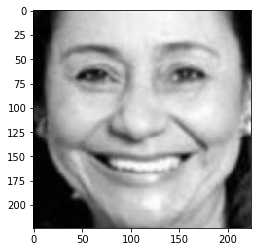

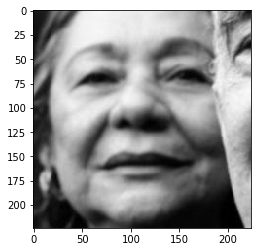

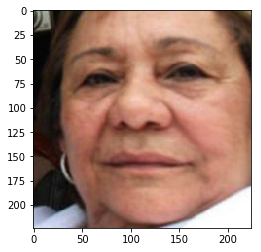

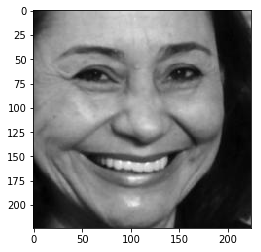

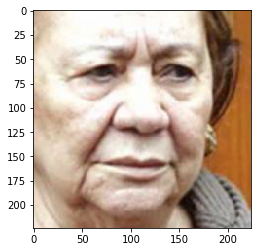

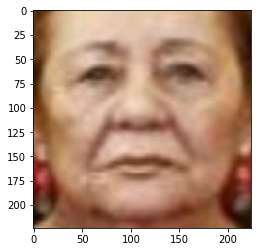

In [11]:
# visualizing some photos of the family member
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for i in allPhotos['../input/train/F0470/MID2']:
    img=mpimg.imread(i)
    imgplot = plt.imshow(img)
    plt.show()

In [12]:
#Creating batch of images 
from random import choice, sample
def getImages(p1,p2):
    p1 = read_img(choice(allPhotos[p1]))
    p2 = read_img(choice(allPhotos[p2]))
    return p1,p2

def getMiniBatch(batch_size=16, data=train):
    p1 = []; p2 = []; Y = []
    batch = sample(data, batch_size//2)
    for x in batch:
        _p1, _p2 = getImages(*x)
        p1.append(_p1);p2.append(_p2);Y.append(1)
    while len(Y) < batch_size:
        _p1,_p2 = tuple(np.random.choice(ppl,size=2, replace=False))
        if (_p1,_p2) not in train+val and (_p2,_p1) not in train+val:
            _p1,_p2 = getImages(_p1,_p2)
            p1.append(_p1);p2.append(_p2);Y.append(0) 
    return [np.array(p1),np.array(p2)], np.array(Y)

In [13]:
def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)
  
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [14]:
def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [15]:
from keras.layers import Input, Dense, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract
def baseline_model():
    input_1 = Input(shape=(224, 224, 3))
    input_2 = Input(shape=(224, 224, 3))

    base_model = VGGFace(model='resnet50', include_top=False)

    for x in base_model.layers[:-3]:
        x.trainable = True
    for x in base_model.layers[-3:]:
        x.trainable=False

    x1 = base_model(input_1)
    x2 = base_model(input_2)

#     x1_ = Reshape(target_shape=(7*7, 2048))(x1)
#     x2_ = Reshape(target_shape=(7*7, 2048))(x2)
#     #
#     x_dot = Dot(axes=[2, 2], normalize=True)([x1_, x2_])
#     x_dot = Flatten()(x_dot)

    x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4 = Subtract()([x1_, x2_])
    x = Concatenate(axis=-1)([x4, x3])

    x = Dense(100, activation="relu")(x)
    x = Dropout(0.01)(x)
    out = Dense(1, activation="sigmoid")(x)

    model = Model([input_1, input_2], out)
    
    # loss="binary_crossentropy"
    model.compile(loss="binary_crossentropy",optimizer=Adam(1e-5),metrics=['accuracy',auc])

    model.summary()

    return model

In [16]:
model = baseline_model()

94699520/94694792 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_resnet50 (Model)        multiple             23561152    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 2048)

In [17]:
reducelr = ReduceLROnPlateau(monitor='val_auc', mode='max',patience=6,factor=0.1,verbose=1)

model_checkpoint  = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True,
                                    save_weights_only=True, monitor='val_auc', mode='max', verbose=1)

early_stopping = EarlyStopping(monitor='val_auc', patience=15, mode='max')

callbacks_list = [reducelr, model_checkpoint, early_stopping]

def Generator(batch_size,data):
    while True:
        yield getMiniBatch(batch_size=batch_size, data=data)

train_gen = Generator(batch_size=16,data=train)
val_gen = Generator(batch_size=16,data=val)
model.fit_generator( train_gen, samples_per_epoch=100, epochs=50, 
                          validation_data=val_gen, validation_steps=100, use_multiprocessing=True,
                          verbose=1, workers=4)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=50, validation_data=<generator..., validation_steps=100, use_multiprocessing=True, verbose=1, workers=4, steps_per_epoch=100)`


Epoch 1/50

/opt/conda/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



100/100 [==============================] - 67s 672ms/step - loss: 4.3128 - acc: 0.5763 - auc: 0.6099 - val_loss: 3.2481 - val_acc: 0.6994 - val_auc: 0.7679
Epoch 2/50
100/100 [==============================] - 41s 413ms/step - loss: 3.9275 - acc: 0.6063 - auc: 0.6445 - val_loss: 3.2864 - val_acc: 0.6869 - val_auc: 0.7434
Epoch 3/50
100/100 [==============================] - 42s 421ms/step - loss: 3.2427 - acc: 0.6581 - auc: 0.6870 - val_loss: 3.4857 - val_acc: 0.6706 - val_auc: 0.7164
Epoch 4/50
100/100 [==============================] - 40s 404ms/step - loss: 3.0146 - acc: 0.6300 - auc: 0.6723 - val_loss: 3.0205 - val_acc: 0.6794 - val_auc: 0.7406
Epoch 5/50
100/100 [==============================] - 40s 404ms/step - loss: 2.2757 - acc: 0.6587 - auc: 0.7064 - val_loss: 2.5122 - val_acc: 0.6450 - val_auc: 0.7133
Epoch 6/50
100/100 [==============================] - 40s 402ms/step - loss: 1.7149 - acc: 0.6544 - auc: 0.7047 - val_loss: 1.7460 - val_acc: 0.6700 - val_auc: 0.7568
Epoch 7/

In [18]:
submission = pd.read_csv('../input/sample_submission.csv')
submission['p1'] = submission.img_pair.apply( lambda x: '../input/test/'+x.split('-')[0] )
submission['p2'] = submission.img_pair.apply( lambda x: '../input/test/'+x.split('-')[1] )
print(submission.shape)
submission.head()

(5310, 4)


,img_pair,is_related,p1,p2
0,face05508.jpg-face01210.jpg,0,../input/test/face05508.jpg,../input/test/face01210.jpg
1,face05750.jpg-face00898.jpg,0,../input/test/face05750.jpg,../input/test/face00898.jpg
2,face05820.jpg-face03938.jpg,0,../input/test/face05820.jpg,../input/test/face03938.jpg
3,face02104.jpg-face01172.jpg,0,../input/test/face02104.jpg,../input/test/face01172.jpg
4,face02428.jpg-face05611.jpg,0,../input/test/face02428.jpg,../input/test/face05611.jpg


In [19]:

probs = []
for i,j in tqdm([ (0,500),(500,1000),(1000,1500),(1500,2000),(2000,2500),
                 (2500,3000),(3000,3500),(3500,4000),(4000,4500),(4500,5000),(5000,5310) ]):
    imgs1 = np.array( [ read_img(photo) for photo in submission.p1.values[i:j] ] )
    imgs2 = np.array( [ read_img(photo) for photo in submission.p2.values[i:j] ] )
    prob =  model.predict( [ imgs1, imgs2 ] )
    probs.append(np.squeeze(prob))
    del imgs1,imgs2; gc.collect()

100%|██████████| 11/11 [01:19<00:00,  6.65s/it]


In [20]:
submission.is_related = np.concatenate(probs)
submission.drop( ['p1','p2'],axis=1,inplace=True )
submission.head()

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0.001957
1,face05750.jpg-face00898.jpg,0.960254
2,face05820.jpg-face03938.jpg,0.922596
3,face02104.jpg-face01172.jpg,0.919392
4,face02428.jpg-face05611.jpg,0.821485


### References

* https://www.kaggle.com/hsinwenchang/vggface-baseline-197x197
* https://www.kaggle.com/vaishvik25/blend-of-smiles    